In [257]:
import torch
import torchvision 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#### Multi-Layer Perceptrons (MLPs)
An MLP is a type of feedforward artificial neural network. It consists of:
- An input Layer
- One or more hidden layers
- An output layer
<p>Each layer (except the input layer) typically applies a linear transformation (weights and biases) followed by a non-linear activation function.</p>

In [258]:
dataset = torchvision.datasets.EMNIST(root="./data", download=True, split="letters")
dataset

Dataset EMNIST
    Number of datapoints: 124800
    Root location: ./data
    Split: Train

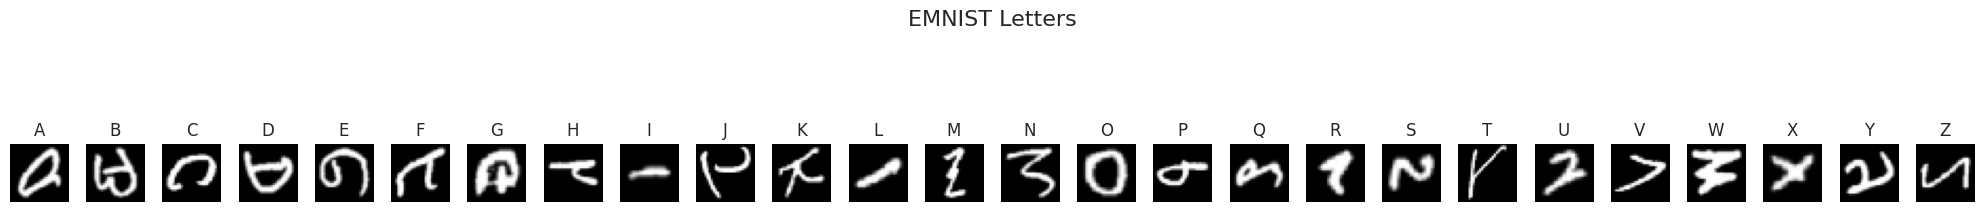

In [259]:
letter_images = {}

for img, label in dataset:
    if label not in letter_images and 1 <= label <= 26:
        letter_images[label] = img
    if len(letter_images) == 26:
        break

sorted_labels = sorted(letter_images.keys())

fig, axes = plt.subplots(1, 26, figsize=(20, 3))
for idx, label in enumerate(sorted_labels):
    axes[idx].imshow(letter_images[label], cmap='gray')
    axes[idx].set_title(chr(label + 64))  # Convert label to letter
    axes[idx].axis('off')

plt.suptitle("EMNIST Letters", fontsize=16)
plt.tight_layout()
plt.show()


In [260]:
X = dataset.data
Y = dataset.targets

In [261]:
len(dataset) * 0.8

99840.0

In [262]:
train_size = 99840
Xtrain = X[:train_size] /255
Ytrain = Y[:train_size]
Ytrain = Y[:train_size].unsqueeze(1)

Xtest = X[train_size:] /255
Ytest = Y[train_size:]
Ytest = Y[train_size:].unsqueeze(1)

In [263]:
X.shape

torch.Size([124800, 28, 28])

In [264]:
28*28

784

In [265]:
ninput = 784
nhidden = 256
nhidden2 = 256
batch_size =64
nclasses = len(dataset.classes)

In [266]:
# Layer 1 (Input to Hidden)
W1 = torch.randn(ninput, nhidden, requires_grad=True) * torch.sqrt(torch.tensor(2.0) / (ninput + nhidden))
b1 = torch.randn(1, nhidden, requires_grad=True)
# Layer 2 (Hidden to Hidden)
W2 = torch.randn(nhidden, nhidden2, requires_grad=True)* torch.sqrt(torch.tensor(2.0) / (nhidden + nhidden2))
b2 = torch.randn(1, nhidden2, requires_grad=True)
# Layer 2 (Hidden to Output)
W3 = torch.randn(nhidden2, nclasses, requires_grad=True)* torch.sqrt(torch.tensor(2.0) / (nhidden + nhidden2))
b3 = torch.zeros(1, nclasses, requires_grad=True)

In [267]:
num_batches = len(Xtrain) // batch_size

In [268]:
alpha = 0.1
losses = []
val_losses = []

for epoch in range(10):
    epoch_loss = 0.0
    for i in range(num_batches):
        # Create batch
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        X_batch = Xtrain[start_idx:end_idx]
        Y_batch = Ytrain[start_idx:end_idx]

        # Forward pass
        Z1 = X_batch.view(-1, ninput) @ W1 + b1     # Linear Transformation
        A1 = torch.tanh(Z1)     # Activation
        Z2 = A1 @ W2 + b2       
        A2 = torch.tanh(Z2)
        Z3 = A2 @ W3 + b3
        zmax = Z3.max(dim=1, keepdim=True).values
        znorm = Z3 - zmax
        zexp = znorm.exp()
        zexp_sum = zexp.sum(dim=1, keepdim=True)
        zexp_sum_inv = zexp_sum ** (-1)
        probs = zexp * zexp_sum_inv
        log_probs = probs.log()
        L = -log_probs[torch.arange(len(Y_batch)), Y_batch.squeeze()].mean()
        epoch_loss += L.item()

        # Backward pass
        dL_dL = torch.ones_like(L)
        dL_dlogprobs = torch.zeros_like(log_probs)
        dL_dlogprobs[torch.arange(len(Y_batch)), Y_batch.squeeze()] = -dL_dL / len(Y_batch)
        dL_dprobs = dL_dlogprobs * 1 / probs
        dL_dzexp = dL_dprobs * zexp_sum_inv
        dL_dzexp_sum_inv = (dL_dprobs * zexp).sum(1, keepdim=True)
        dL_dzexp_sum = -1 * dL_dzexp_sum_inv * zexp_sum**(-2)
        dL_dzexp += dL_dzexp_sum
        dL_dznorm = dL_dzexp * zexp.clone()
        dL_dzmax = -dL_dznorm.sum(1, keepdim=True)
        dL_dZ = dL_dznorm
        dL_dZ += torch.nn.functional.one_hot(Z3.max(dim=1).indices, nclasses) * dL_dzmax
        dL_dW3 = A2.T @ dL_dZ
        dL_db3 = dL_dZ.sum(0, keepdim=True)
        dL_dA2 = dL_dZ @ W3.T
        dL_dZ2 = dL_dA2 * (1 - A2**2)
        dL_dW2 = A1.T @ dL_dZ2
        dL_db2 = dL_dZ2.sum(0, keepdim=True)
        dL_dA1 = dL_dZ2 @ W2.T
        dL_dZ1 = dL_dA1 * (1 - A1**2)
        dL_dW1 = X_batch.view(-1, ninput).T @ dL_dZ1
        dL_db1 = dL_dZ1.sum(0, keepdim=True)

        with torch.no_grad():
            W1 -= alpha * dL_dW1
            b1 -= alpha * dL_db1
            W2 -= alpha * dL_dW2
            b2 -= alpha * dL_db2
            W3 -= alpha * dL_dW3
            b3 -= alpha * dL_db3

    # Calculate validation loss
    val_loss = 0.0
    with torch.no_grad():
        for j in range(len(Xtest) // batch_size):
            start_idx = j * batch_size
            end_idx = (j + 1) * batch_size
            X_val = Xtest[start_idx:end_idx]
            Y_val = Ytest[start_idx:end_idx]

            Z1_val = X_val.view(-1, ninput) @ W1 + b1
            A1_val = torch.tanh(Z1_val)
            Z2_val = A1_val @ W2 + b2
            A2_val = torch.tanh(Z2_val)
            Z3_val = A2_val @ W3 + b3
            val_loss += -torch.nn.functional.log_softmax(Z3_val, dim=1)[torch.arange(len(Y_val)), Y_val.squeeze()].mean().item()
    val_loss /= (len(Xtest) // batch_size)

    losses.append(epoch_loss / num_batches)
    val_losses.append(val_loss)

    print(f"Epoch {epoch}, Loss: {losses[-1]}, Validation Loss: {val_losses[-1]}")

Epoch 0, Loss: 1.02310149663916, Validation Loss: 0.6608651258242436
Epoch 1, Loss: 0.538368667748112, Validation Loss: 0.46905659448641995
Epoch 2, Loss: 0.4077065501648646, Validation Loss: 0.39746980072978216
Epoch 3, Loss: 0.3421509676063672, Validation Loss: 0.36085952383776504
Epoch 4, Loss: 0.2997435765436445, Validation Loss: 0.3398466588786015
Epoch 5, Loss: 0.26850368037151223, Validation Loss: 0.3268959554915245
Epoch 6, Loss: 0.24373860493875465, Validation Loss: 0.31867166289534327
Epoch 7, Loss: 0.22319359307487804, Validation Loss: 0.31371104671404915
Epoch 8, Loss: 0.20561259648738764, Validation Loss: 0.31110656417142124
Epoch 9, Loss: 0.19021946100327067, Validation Loss: 0.31018320053624804


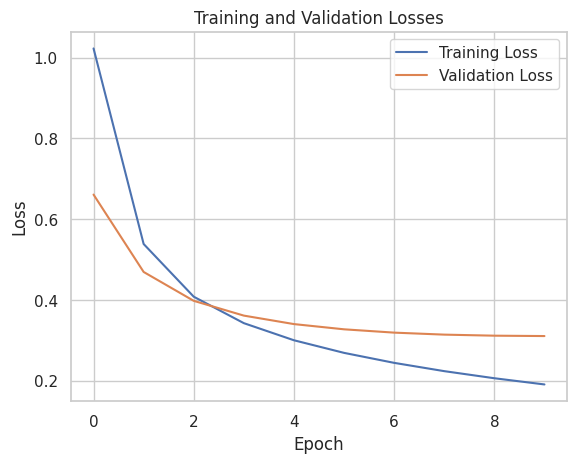

In [269]:
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [270]:
correct = 0
total = 0

with torch.no_grad():
    for i in range(len(Xtest)):
        Z1 = Xtest[i].view(1, -1) @ W1 + b1
        A1 = torch.tanh(Z1)
        Z2 = A1 @ W2 + b2
        A2 = torch.tanh(Z2)
        Z3 = A2 @ W3 + b3
        predicted_class = torch.argmax(Z3, dim=1)

        if predicted_class == Ytest[i]:
            correct += 1
        total += 1
accuracy = correct / total
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.9038461538461539
